In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.cluster import OPTICS

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

angles=4
train_limit=30000
x_train = (x_train.astype('float32') / 255.)[:train_limit]
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(30000, 28, 28)
(10000, 28, 28)


In [3]:
# Create an empty array to store the rotated matrices
rotated_train = np.empty_like(np.repeat(x_train,angles,axis=0))
static_train = np.empty_like(np.repeat(x_train,angles,axis=0))

for i in range(rotated_train.shape[0]):
    rotated_matrix = np.rot90(x_train[int(i//angles)], k=i%angles)  # k=1 for a 90-degree rotation
    rotated_train[i] = rotated_matrix
    static_train[i] = x_train[int(i//angles)]

        
# Create an empty array to store the rotated matrices
rotated_test = np.empty_like(np.repeat(x_test,angles,axis=0))
static_test = np.empty_like(np.repeat(x_test,angles,axis=0))

for i in range(rotated_test.shape[0]):
    rotated_matrix = np.rot90(x_test[int(i//angles)], k=i%angles)  # k=1 for a 90-degree rotation
    rotated_test[i] = rotated_matrix
    static_test[i] = x_test[int(i//angles)]


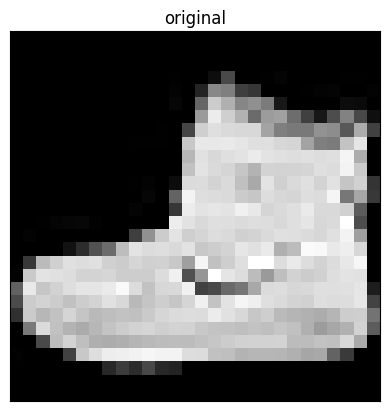

In [4]:
ax = plt.subplot()
plt.imshow(static_train[0])
plt.title("original")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



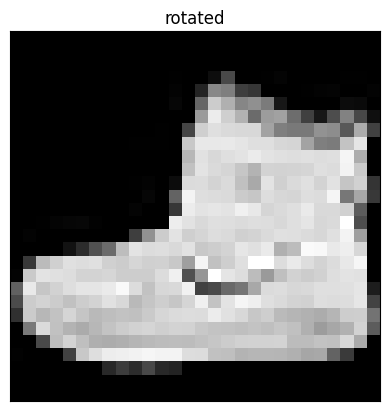

In [5]:
ax = plt.subplot()
plt.imshow(rotated_train[0])
plt.title("rotated")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [6]:
train_transform = np.empty((static_train.shape[0], static_train.shape[1], static_train.shape[2], 3), dtype=float)
for i, matrix in enumerate(static_train):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    train_transform[i, :, :, 0] = matrix
    train_transform[i, :, :, 1] = magnitude
    train_transform[i, :, :, 2] = phase
print(train_transform.shape)

(120000, 28, 28, 3)


In [7]:
rot_train_transform = np.empty((rotated_train.shape[0], rotated_train.shape[1],rotated_train.shape[2], 3), dtype=float)
for i, matrix in enumerate(rotated_train):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    rot_train_transform[i, :, :, 0] = matrix
    rot_train_transform[i, :, :, 1] = magnitude
    rot_train_transform[i, :, :, 2] = phase
print(rot_train_transform.shape)

(120000, 28, 28, 3)


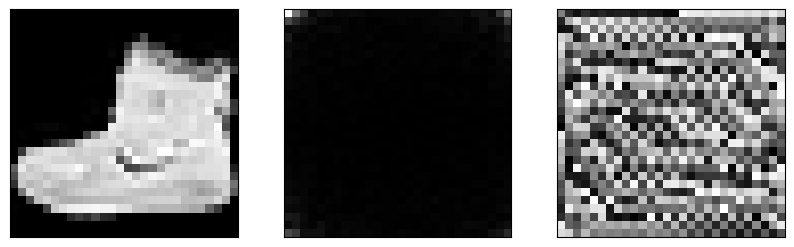

In [8]:
#A plot of the original image, it's magnitude spectrum, and its phase spectrum
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(10,5))
plt.gray()

ax[0].imshow(rot_train_transform[0][:,:,0])
ax[1].imshow(rot_train_transform[1][:,:,1])
ax[2].imshow(rot_train_transform[2][:,:,2])


ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)


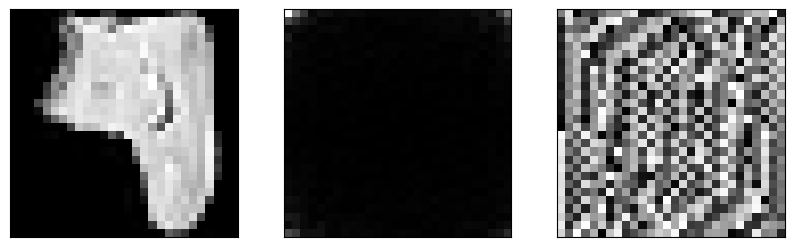

In [9]:
#A plot of a rotated image, its magnitude spectrum, and its phase spectrum
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(10,5))
ax[0].imshow(rot_train_transform[1][:,:,0])
ax[1].imshow(rot_train_transform[1][:,:,1])
ax[2].imshow(rot_train_transform[1][:,:,2])

plt.gray()
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

In [10]:
test_transform = np.empty((static_test.shape[0], static_test.shape[1],static_test.shape[2], 3), dtype=float)
for i, matrix in enumerate(static_test):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    test_transform[i, :, :, 0] = matrix
    test_transform[i, :, :, 1] = magnitude
    test_transform[i, :, :, 2] = phase
print(test_transform.shape)

(40000, 28, 28, 3)


In [11]:
rot_test_transform = np.empty((rotated_test.shape[0], rotated_test.shape[1],rotated_test.shape[2], 3), dtype=float)
for i, matrix in enumerate(rotated_test):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    rot_test_transform[i, :, :, 0] = matrix
    rot_test_transform[i, :, :, 1] = magnitude
    rot_test_transform[i, :, :, 2] = phase
print(rot_test_transform.shape)

(40000, 28, 28, 3)


In [12]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 3)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Flatten(),
          layers.Dense(32, activation='relu'),
          layers.Dense(16, activation='relu'),
          layers.Dense(8, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
          layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def reduced(self,x):
        return self.encoder(x)
    
shape = train_transform.shape[1:]
print(shape)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

(28, 28, 3)


In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredLogarithmicError(),metrics=['accuracy'])

In [14]:
autoencoder.fit(rot_train_transform, train_transform,
                epochs=10,
                shuffle=True,
                validation_data=(rot_test_transform, test_transform))

Epoch 1/10


I0000 00:00:1703366567.737881   13302 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3750/3750 [==============================] - 43s 9ms/step - loss: 0.3755 - accuracy: 0.7822 - val_loss: 0.3717 - val_accuracy: 0.7854
Epoch 2/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3703 - accuracy: 0.7857 - val_loss: 0.3700 - val_accuracy: 0.7861
Epoch 3/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3690 - accuracy: 0.7869 - val_loss: 0.3690 - val_accuracy: 0.7876
Epoch 4/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3683 - accuracy: 0.7875 - val_loss: 0.3687 - val_accuracy: 0.7878
Epoch 5/10
3750/3750 [==============================] - 30s 8ms/step - loss: 0.3679 - accuracy: 0.7877 - val_loss: 0.3682 - val_accuracy: 0.7879
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3677 - accuracy: 0.7878 - val_loss: 0.3681 - val_accuracy: 0.7880
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3675 - accuracy: 0.7879 - val_loss: 0.3680 - val_accuracy: 0.7

In [15]:
encoded_imgs = autoencoder.encoder(rot_test_transform[:12]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

(12, 28, 28, 3)


In [16]:
first_image = decoded_imgs[..., 0]

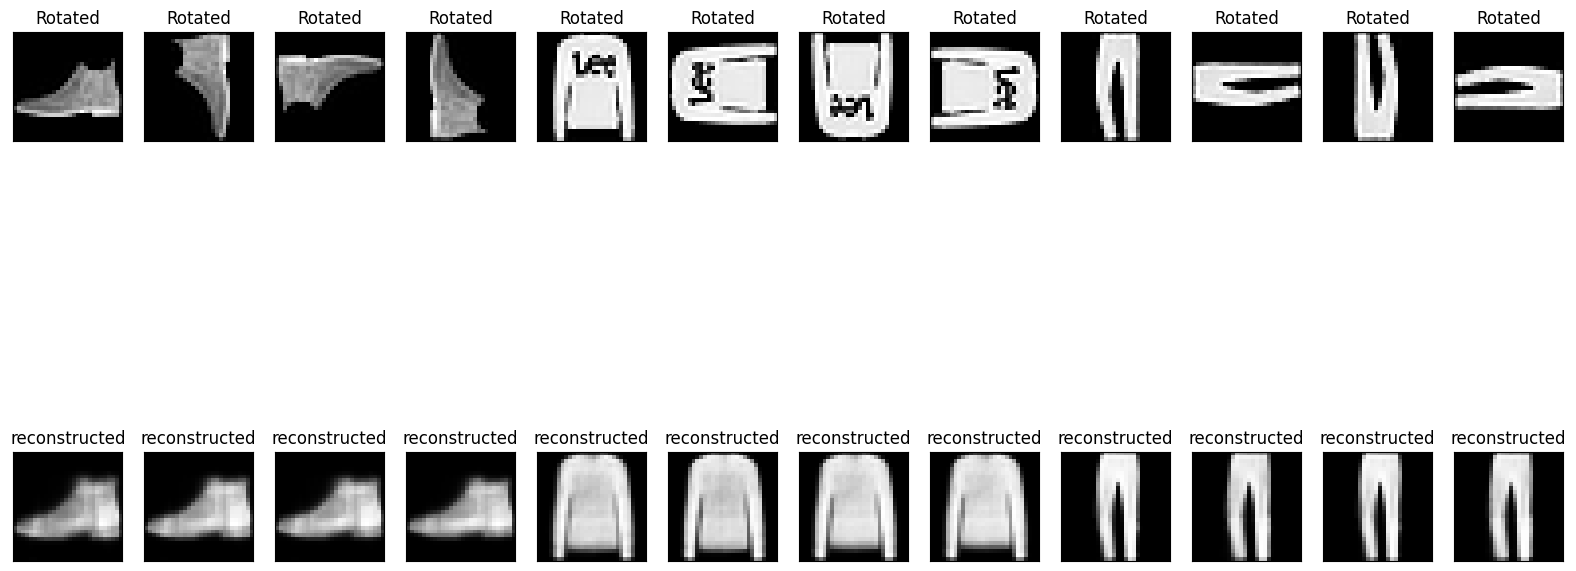

In [17]:
n = 12
plt.figure(figsize=(20, 10))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("Rotated")
    plt.imshow(tf.squeeze(rotated_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(first_image[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()